# Ucitavanje biblioteka za rad 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time

random.seed(time.time())

In [2]:
# broj indeksa za studenta Jovan Dmitrović
ind = '2021/3096'

# odredjivanje parametra S 
S = 0
for i in range(4):
    S += int(ind[len(ind)-i-1])
S %=3

S_dict = {0: 'Rigde regresija',
          1: 'LASSO regresija',
          2: 'Lokalno ponderisana linearna regresija'}

print(f'Parametar S za broj indeksa {ind} je {S}, odnosno algoritam koji je potrebno implementirati je {S_dict[S]}.')

Parametar S za broj indeksa 2021/3096 je 0, odnosno algoritam koji je potrebno implementirati je Rigde regresija.


# Ucitavanje podataka 

In [3]:
data = pd.read_csv('data.csv').to_numpy()
X, y = data[:,0:5], data[:,5]

print('-------------------Ucitani su podaci-------------------')
print(f'Ukupan broj ucitanih primera je: {X.shape[0]}')
print(f'Ukupan broj ucitanih prediktora (dim(X)) je: {X.shape[1]}')


-------------------Ucitani su podaci-------------------
Ukupan broj ucitanih primera je: 341
Ukupan broj ucitanih prediktora (dim(X)) je: 5


# Teorijski osvrt

Dakle, potrebno je implementirati **Ridge regresiju**, koristeci se **polinomijalnom regresijom** ciji je red polinoma unapred odredjen zadatkom i iznosi 2. 

Polinomijalna regresija drugog reda ima sledeci oblik:
$$\hat{y} = \theta_0 + \theta_1x + \theta_2x^2,$$

U ovakvim slucajevima se javlja problem da mali red modela ogranicava ekspresivnost modela, odnosno model ne uspeva da dovoljno dobro isprati dinamiku koju unose ulazni podaci.
Taj problem se resava na dva nacina:
- ili povecavanjem reda modela (sto u vecini slucajeva nije dobro, jer dovodi do preobucavanja)
- ili regularizacijom (odlicna metoda)

Upravo jedan tip regularizacije, tzv. *L2* odnosno *Rigde* regularizaciju potrebno je implementirati ovde i inkorporirati u polinomijalnu regresiju drugog reda.

Regularizacija se uvodi u kriterijumsku funkciju kao sabirak:
$$J(\theta) = L(\hat{y}, y) + \lambda R(\theta),$$
gde je $L(\hat{y}, y)$ funkcija gubitka modela ((srednje) kvadratna greska), $\lambda$ hiper-parametar regularizacija koji odredjuje koliko ce regulazacioni sabirak ($R(\theta)$) biti penalizovan.

Regularizaciona funkcija za Rigde regularizaciju ima sledeci oblik:
$$R_{ridge}(\theta) = \sum_{i=1}^{n}{\theta_i^2},$$ gde je $n$ ukupan broj prediktora, odnosno komponenti vektora $\theta$, modela.

Hiper-parametar regularizacije $\lambda$ odredjujemo unakrsnom validacijom, minimizacijom (srednje) kvadratne greske.

In [4]:
# red polinoma 
p=2

# broj primera
m = X.shape[0] # 341

## Odredjivanje broja parametara vektora $\theta$

U pitanju je **Polinomijalna regresija**, pri cemu je red polimoma postavljen na $p=2$ i ona ima sledeci oblik:
$$\hat{y} = \theta_0 + \theta_1x + \theta_2x^2,$$

Ovakav oblik je validan kada je broj prediktora jedan 1. Medjutim, u slucajevima kada je broj prediktora razlicit od nule, postoje i unakrasna mnozenja pojedinacnih prediktora, po principu svaki sa svakim ($x_1x_2, x_1x_3, x_1x_4, x_1x_5, x_2x_3, ...$) i, naravno, postoje cisto kvadratni "novi" prediktori ($x_1^2, x_2^2, x_3^2, x_4^2, x_5^2$). 

Ukupan broj parametara u vektoru $\theta$ odredjen je:
- $\theta_0$ srednja vrednost - #1 (ovu vrednost odredjujemo kao srednju vrednost izlaznih primera $y_i$)
- 5 "linearnih" prediktora - #5
- 5 "kvadratnih" prediktora - #5
- kombinacija bez ponavljanja 5 "linearnih" prediktora - #10.

Dakle, ukupno 21 parametar, koji se nalaze u vektoru $\theta$, odnosno 20 prediktora.

In [5]:
# broj prediktora 
n=20

print(f'Red polinoma: p = {p}\nBroj prediktora: n = {n}\nBroj primera: m = {m}\n')

# theta 0
theta_0 = np.mean(y)

print('Odredjeni parametar theta_0 je : {:.3f}'.format(theta_0))

Red polinoma: p = 2
Broj prediktora: n = 20
Broj primera: m = 341

Odredjeni parametar theta_0 je : 153.745


# Implementacija potrebnih funkcija

In [6]:
def read_data(path: str='data.csv', separator_index: int=5) -> tuple:
    
    data = pd.read_csv('data.csv').to_numpy()
    X, y = data[:,0:separator_index], data[:,separator_index]
    
    return X, y

In [7]:
def factoriel(n: int) -> int:
    
    """
        Funkcija za preracunavanje faktorijela nekog prirodnog broja.
    """
    
    f = 1
    while n>1:
        f *= n
        n -=1
    return f

In [8]:
def make_polynomial_features(X: np.ndarray, p: int=2) -> np.ndarray:
    
    """
        Funkcija za kreiranje polinomijalnih obelezja od 
        obelezja datih kroz n-dimenzionu matricu X. 
        
        Broj kolona matrice X predstavlja broj prediktora, a broj njenih 
        vrsta prestavlja broj primera. 
        
        Funkcija radi za drugi red polinoma (p=2).
    """
    
    # broj primera
    m = X.shape[0] 
    
    # stari broj prediktora - za linearnu regresiju
    n_old = X.shape[1] 
    
    # novi broj prediktora
    n = int(p*n_old + factoriel(n_old)/(factoriel(n_old-p)*factoriel(p)))
    
    # kreiranje polinomijalnih obelezja svih stepena
    features = []
    for i in range(n_old):
        features.append(list(X[:,i]))
        
        for j in range(n_old):
            if j >= i:
                product = X[:,i]*X[:,j]
                features.append(list(product))
    
    return np.array(features, dtype='float32').reshape((m, n))

In [9]:
def train_test_data_split(X: np.ndarray, y: np.ndarray, split_ratio: float=0.8) -> tuple:
    
    """
        Funkcija za splitovanje svih dostupnih podataka na trening/obucavajuce
        i test podatke prema zadatom postotku (split_ratio).
        
    """
    
    m = X.shape[0]
    
    train_set_size = int(m*split_ratio)
    
    ind = np.arange(0,m).tolist()
    
    train_set_ind = random.sample(ind, k=train_set_size)
    test_set_ind = list(set(ind) - set(train_set_ind))
    
    X_train, y_train = X[train_set_ind], y[train_set_ind]
    X_test, y_test = X[test_set_ind], y[test_set_ind]
    
    return X_train, y_train, X_test, y_test

In [10]:
def get_fold_indeces(m: int, k: int=5) -> list:
    
    """
        Funkcija za dohvatanje listi pocetnih i krajnjih indeksa
        foldova na osnovu prosledjenog broja foldova - k i velicine celokupnog seta
        podataka - m.
        
    """
    
    fold_size = int(m/k)
    
    fold_indeces = []
    
    for i in range(k):
        
        fold_indeces.append([i*fold_size, (i+1)*fold_size if i != k-1 else m])
    
    return fold_indeces  

In [11]:
def get_fold(X: np.ndarray, y: np.ndarray, fold_index: list) -> tuple:
    
    """
        Funkcija za dohvatanje jednog folda podataka na osnovu proslednje
        liste koja sadrzi pocetni i krajnji indeks jednog folda.
    """
    
    X_fold = X[fold_index[0]:fold_index[1],:]
    
    y_fold = y[fold_index[0]:fold_index[1]]
    
    return (X_fold, y_fold)

In [12]:
def concat_folds(fold_1: tuple, fold_2: tuple=None) -> tuple:
    
    """
        Funkcija za spajanje dva odvojena folda podataka 
        koji u sebi sadrze i ulazne i izlazne podatke.
    """
    
    try:
        X_1, y_1 = fold_1[0], fold_1[1]
        X_2, y_2 = fold_2[0], fold_2[1]

        X_concat = np.concatenate((X_1, X_2), axis=0)
        Y_concat = np.concatenate((y_1, y_2), axis=0)
        
    except:
        X_1, y_1 = fold_1[0], fold_1[1]
        return (X_1, y_1)
    
    return (X_concat, Y_concat)

In [13]:
def get_validation_and_train_folds(X: np.ndarray, y: np.ndarray, validation_fold_index: int, fold_indeces: list) -> tuple:
    
    """
        Funkcija za dohvatanje jednog folda podataka za validaciju i ostatak podataka
        za obucavanje.
    """
    
    validation_fold = get_fold(X, y, fold_indeces[validation_fold_index])
    
    train_folds = None
    
    for i in range(len(fold_indeces)):
        if i != validation_fold_index:
            train_fold = get_fold(X, y, fold_indeces[i])
            train_folds = concat_folds(train_fold, train_folds)
    
    return validation_fold, train_folds

In [14]:
def get_statistics(X: np.ndarray) -> tuple:
    
    """
        Funkcija za dohvatanje statistika - srednja vrednost i standardna devijacija. 
        Za svaka od kolona matrice X vrsi se izracunavanje statistika, s obzirom na to da
        one predstavljaju posebne prediktore.
    """
    
    mu = np.zeros((X.shape[1],))
    std = np.zeros((X.shape[1],))
    
    for i in range(X.shape[1]):
        mu[i] = np.mean(X[:,i])
        std[i] = np.std(X[:,i])
    
    return mu, std

In [15]:
def standardize(X: np.ndarray, mu: np.ndarray, std: np.ndarray) -> np.ndarray:
    
    """
        Funkcija za standardizaciju prediktora - postavljanje prediktora na istu skalu.
        Svaka kolona matrice X se standardizuje sa sebi svojstvenim statistikama - mu i std,
        s obzirom na to da su to posebni prediktori i da u opstem slucaju ne moraju biti na istoj skali.
    """
    
    for i in range(X.shape[1]):
        X_std = X[:,i] - mu[i]*np.ones((X.shape[0],))
        X[:,i] = X_std/std[i]
        
    return X

In [16]:
def center_outputs(y: np.ndarray) -> float:
    
    """
        Funkcija za centriranje izlaznih podataka oko
        sopstevene srednje vrednosti.
    """
    
    y_mean = np.mean(y)
    
    y_center = y-y_mean
    
    return y_center

In [17]:
def calculate_theta_ridge(X: np.ndarray, y_center: np.ndarray, lambda_param: float) -> np.ndarray:
    
    """
        Funkcija za analiticko racunanje optimalnih parametara Theta koristeci se 
        Ridge regresijom. 
    """
    
    n = X.shape[1]
    theta = np.zeros((n,), dtype='float32')
    
    theta = np.linalg.inv(X.transpose()@X + lambda_param*np.identity(n))@X.transpose()@y_center
    
    return theta

In [18]:
def l2_norm(vec_1: np.ndarray, vec_2: np.ndarray=None) -> float:
    
    """
        Funkcija za racunanje L2 norme vektora.
        Racuna se suma kvadrata svih elemenata vektora.
    """
    try:
        l2_norm = np.linalg.norm(vec_1-vec_2) # linalg.norm vraca klasicnu normu vektora, sa korenom
    except:
        l2_norm = np.linalg.norm(vec_1)
    
    return l2_norm**2

In [19]:
def predict(X: np.ndarray, theta: np.ndarray, theta_0: float) -> np.ndarray:
    
    """
        Funkcija koja vrsi predikciju, odnosno daje estimirane
        izlazne vrednosti na osnovu dosada formiranog modela.
    """
    
    y_hat = theta_0 + (theta.reshape(1,-1)@X.transpose()).flatten() 
    
    return y_hat

In [20]:
def mse(y_hat: np.ndarray, y_true: np.ndarray, root: bool=False) -> float:
    
    """
        Funkcija za racunananje (korena) srednje kvadratne greske
        predikcije modela. Dakle, ujedno funkcija za MSE i RMSE.
    """
    
    l = y_true.size
    
    if root:
        value = (l2_norm(y_hat, y_true)/l)**0.5
    else:
        value = l2_norm(y_hat, y_true)/l
    
    return value

In [21]:
def loss(y_hat: np.ndarray, y_true: np.ndarray, theta: np.ndarray, lambda_param: float=0.0) -> float:
    
    """
        Funkcija za racunanje vrednosti funkcije gubitka - loss funkcije.
        Tehnicki, ono se sada, tj. sa regularizacijom zove kriterijumska funkcija, ali zbog
        lakseg asociranja, uzeto je ime funkcija gubitka.
    """
    
    mean_sq_error = mse(y_hat, y_true) 
    regularization_part = lambda_param*l2_norm(theta)
    
    loss = mean_sq_error + regularization_part
    
    return loss

In [22]:
def cv_ridge(X_train: np.ndarray, y_train: np.ndarray, k: int=10, lambda_param: float = 0.0) -> tuple:
    
    """
        Funkcija za unakrsnu validaciju kod Ridge regresije.
        U funkciji se vrsi sledece:
            - splitovanje podataka na k foldova
            - od k foldova, 1 je validacioni fold, a svi ostali su trenirajuci podaci
            - racunanje srednje vrednosti i std. devijacije obucavajuceg skupa podataka
            - standardizacija obucavajuceg i validacionog skupa sa prethodno izracunatim statistikama
            - nakon toga se vrsi odredjivanje parametara regresije
            - theta0 se odredjuje kao srednja vrednost necentriranih izlaznih vrednosti 
            - theta vektor se odredjuje analitickom folmulom
            - potom se vrsi predikcija tako dobijenog modela za obucavajuci i validacioni skup podataka
            - za obucavajuci i validacioni skup podataka se racuna funkcija gubitka modela - loss
            - racunaju se srednje vrednosti i std. devijacije loss-ova za sve foldove i one se vracaju za obucavajuci i validacioni skup podataka
    """
    
    fold_indeces = get_fold_indeces(m=X_train.shape[0], k=k)
    
    loss_train, loss_val = [], []

    for i in range(k):
        validation_fold, train_folds = get_validation_and_train_folds(X_train, y_train, validation_fold_index=i, fold_indeces=fold_indeces)

        X_train_folds, y_train_folds = train_folds[0], train_folds[1]
        X_val_fold, y_val_fold = validation_fold[0], validation_fold[1]

        mu, std = get_statistics(X_train_folds)

        X_train_folds_std = standardize(X_train_folds, mu, std)
        X_val_fold_std = standardize(X_train_folds, mu, std)

        theta0 = np.mean(y_train)
        theta = calculate_theta_ridge(X_train_folds_std, center_outputs(y_train_folds), lambda_param)

        y_hat_train = predict(X_train_folds_std, theta, theta0)
        loss_train.append(loss(y_hat_train, y_train_folds, theta, lambda_param))
        
        y_hat_val = predict(X_val_fold_std, theta, theta0)
        loss_val.append(loss(y_hat_val, y_val_fold, theta))
    
    mean_train, std_train = np.mean(np.array(loss_train)), np.mean(np.std(loss_train))
    mean_val, std_val = np.mean(np.array(loss_val)), np.mean(np.std(loss_val))
    
    return mean_train, std_train, mean_val, std_val

In [23]:
def optimal_lambda_search(X_train: np.ndarray, y_train: np.ndarray, lambdas: np.ndarray, verbose: bool=False) -> float:
    
    """
        Funkcija za pretrazivanje optimalnog hiper-parametra Rigde regresije.
        Funkcija vrsi unakrsnu validaciju za svako lambda iz prosledjenog niza lambdas 
        i odredjuje optimalnu vrednost lambda parametra kao onu koja je dala minimalnu
        vrednost srednje kvadratne greske na validacionom skupu.
    """
    
    mean_train_list, std_train_list = [], []
    mean_val_list, std_val_list = [], []

    for i, lambda_param in enumerate(lambdas):
        mean_train, std_train, mean_val, std_val = cv_ridge(X_train, y_train, k=10, lambda_param=lambda_param)

        mean_train_list.append(mean_train)
        std_train_list.append(std_train)

        mean_val_list.append(mean_val)
        std_val_list.append(std_val)
        
        if verbose:
            percentage = 100*i/lambdas.size
            print('Pretrazeno je {:.5}% prosledjenih podataka.'.format(percentage), end='\r')

    mean_train_arr = np.array(mean_train_list)
    std_train_arr = np.array(std_train_list)

    mean_val_arr = np.array(mean_val_list)
    std_val_arr = np.array(std_val_list)

    fig = plt.figure(figsize=(12,12), dpi=100)
    plt.plot(lambdas, mean_train_arr, color='darkorange', label='obucavajuci skup')
    plt.fill_between(lambdas, mean_train_arr - std_train_arr, mean_train_arr + std_train_arr, alpha=0.2, color='bisque')

    plt.plot(lambdas, mean_val_arr, color='royalblue', label='validacioni skup')
    plt.fill_between(lambdas, mean_val_arr - std_val_arr, mean_val_arr + std_val_arr, alpha=0.2, color='lightsteelblue')

    plt.xlabel('$\lambda$')
    plt.ylabel('Loss funcija')
    plt.title('Loss funkcija na obucavajucem i validacionom skupu u zavisnosti od $\lambda$')
    plt.show()
    
    lambda_opt = lambdas[np.argmin(mean_val_arr)]
    print(f'Pronadjena je optimalna vrednost hiper-parametra Lambda: {lambda_opt}')
    
    return lambda_opt

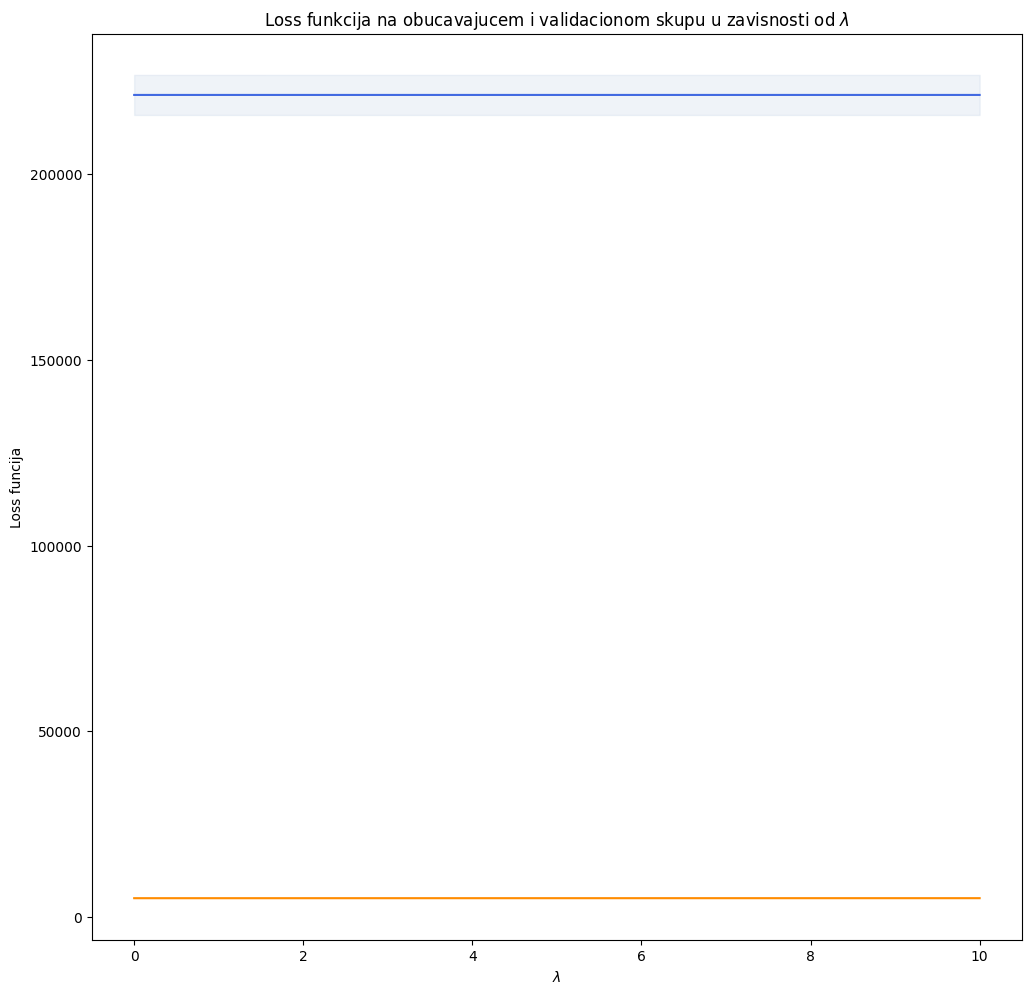

Pronadjena je optimalna vrednost hiper-parametra Lambda: 10.0


In [24]:
X, y = read_data()
X = make_polynomial_features(X)
X_train, y_train, X_test, y_test = train_test_data_split(X, y, split_ratio=0.8)

lambdas = np.linspace(1e-5, 10, 100000)

lambda_opt = optimal_lambda_search(X_train, y_train, lambdas, verbose=True)